# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (files)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 13:47:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Create a data stream from a local socket

### Install netcat utility

In [ ]:
!apt-get update
!apt-get install -y netcat

Hit:1 http://ports.ubuntu.com/ubuntu-ports jammy InRelease
Get:2 http://ports.ubuntu.com/ubuntu-ports jammy-updates InRelease [128 kB]
Get:3 http://ports.ubuntu.com/ubuntu-ports jammy-backports InRelease [127 kB]
Get:4 http://ports.ubuntu.com/ubuntu-ports jammy-security InRelease [129 kB]
Get:5 http://ports.ubuntu.com/ubuntu-ports jammy-updates/main arm64 Packages [3,484 kB]
Get:6 http://ports.ubuntu.com/ubuntu-ports jammy-updates/restricted arm64 Packages [5,484 kB]
Get:7 http://ports.ubuntu.com/ubuntu-ports jammy-updates/universe arm64 Packages [1,598 kB]
Get:8 http://ports.ubuntu.com/ubuntu-ports jammy-security/universe arm64 Packages [1,300 kB]
Get:9 http://ports.ubuntu.com/ubuntu-ports jammy-security/main arm64 Packages [3,145 kB]
Get:10 http://ports.ubuntu.com/ubuntu-ports jammy-security/restricted arm64 Packages [5,268 kB]
Fetched 20.7 MB in 7s (3,153 kB/s)                                             
Reading package lists... Done
Reading package lists... Done
Building dependenc

### Connect Spark to the socket

In [ ]:
# Create the remote connection
lines = spark.readStream \
            .format("socket") \
            .option("host", "localhost") \
            .option("port", 9999) \
            .load()
# Perform some transformations to the input data (word counter)
from pyspark.sql.functions import explode, split
words = lines.select(explode(split(lines.value, " ")).alias("word"))
word_count = words.groupBy("word").count()

# Send transformed data to the Sink
query = word_count.writeStream \
            .outputMode("complete") \
            .format("console") \
            .start()
query.awaitTermination(300)


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
|hola|    2|
+----+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+------+-----+
|  word|count|
+------+-----+
|    mi|    1|
| pablo|    1|
|nombre|    1|
|    es|    1|
|  hola|    2|
+------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+------+-----+
|  word|count|
+------+-----+
|    mi|    1|
|nombre|    1|
|    de|    1|
| pablo|    1|
|    es|    1|
| nuevo|    1|
|  hola|    3|
+------+-----+

-------------------------------------------
Batch: 5
-------------------------------------------
+------+-----+
|  word|count|
+------+-----+
|    mi|    1|
|nombre|    1|
|    de|    1|
| pa

False

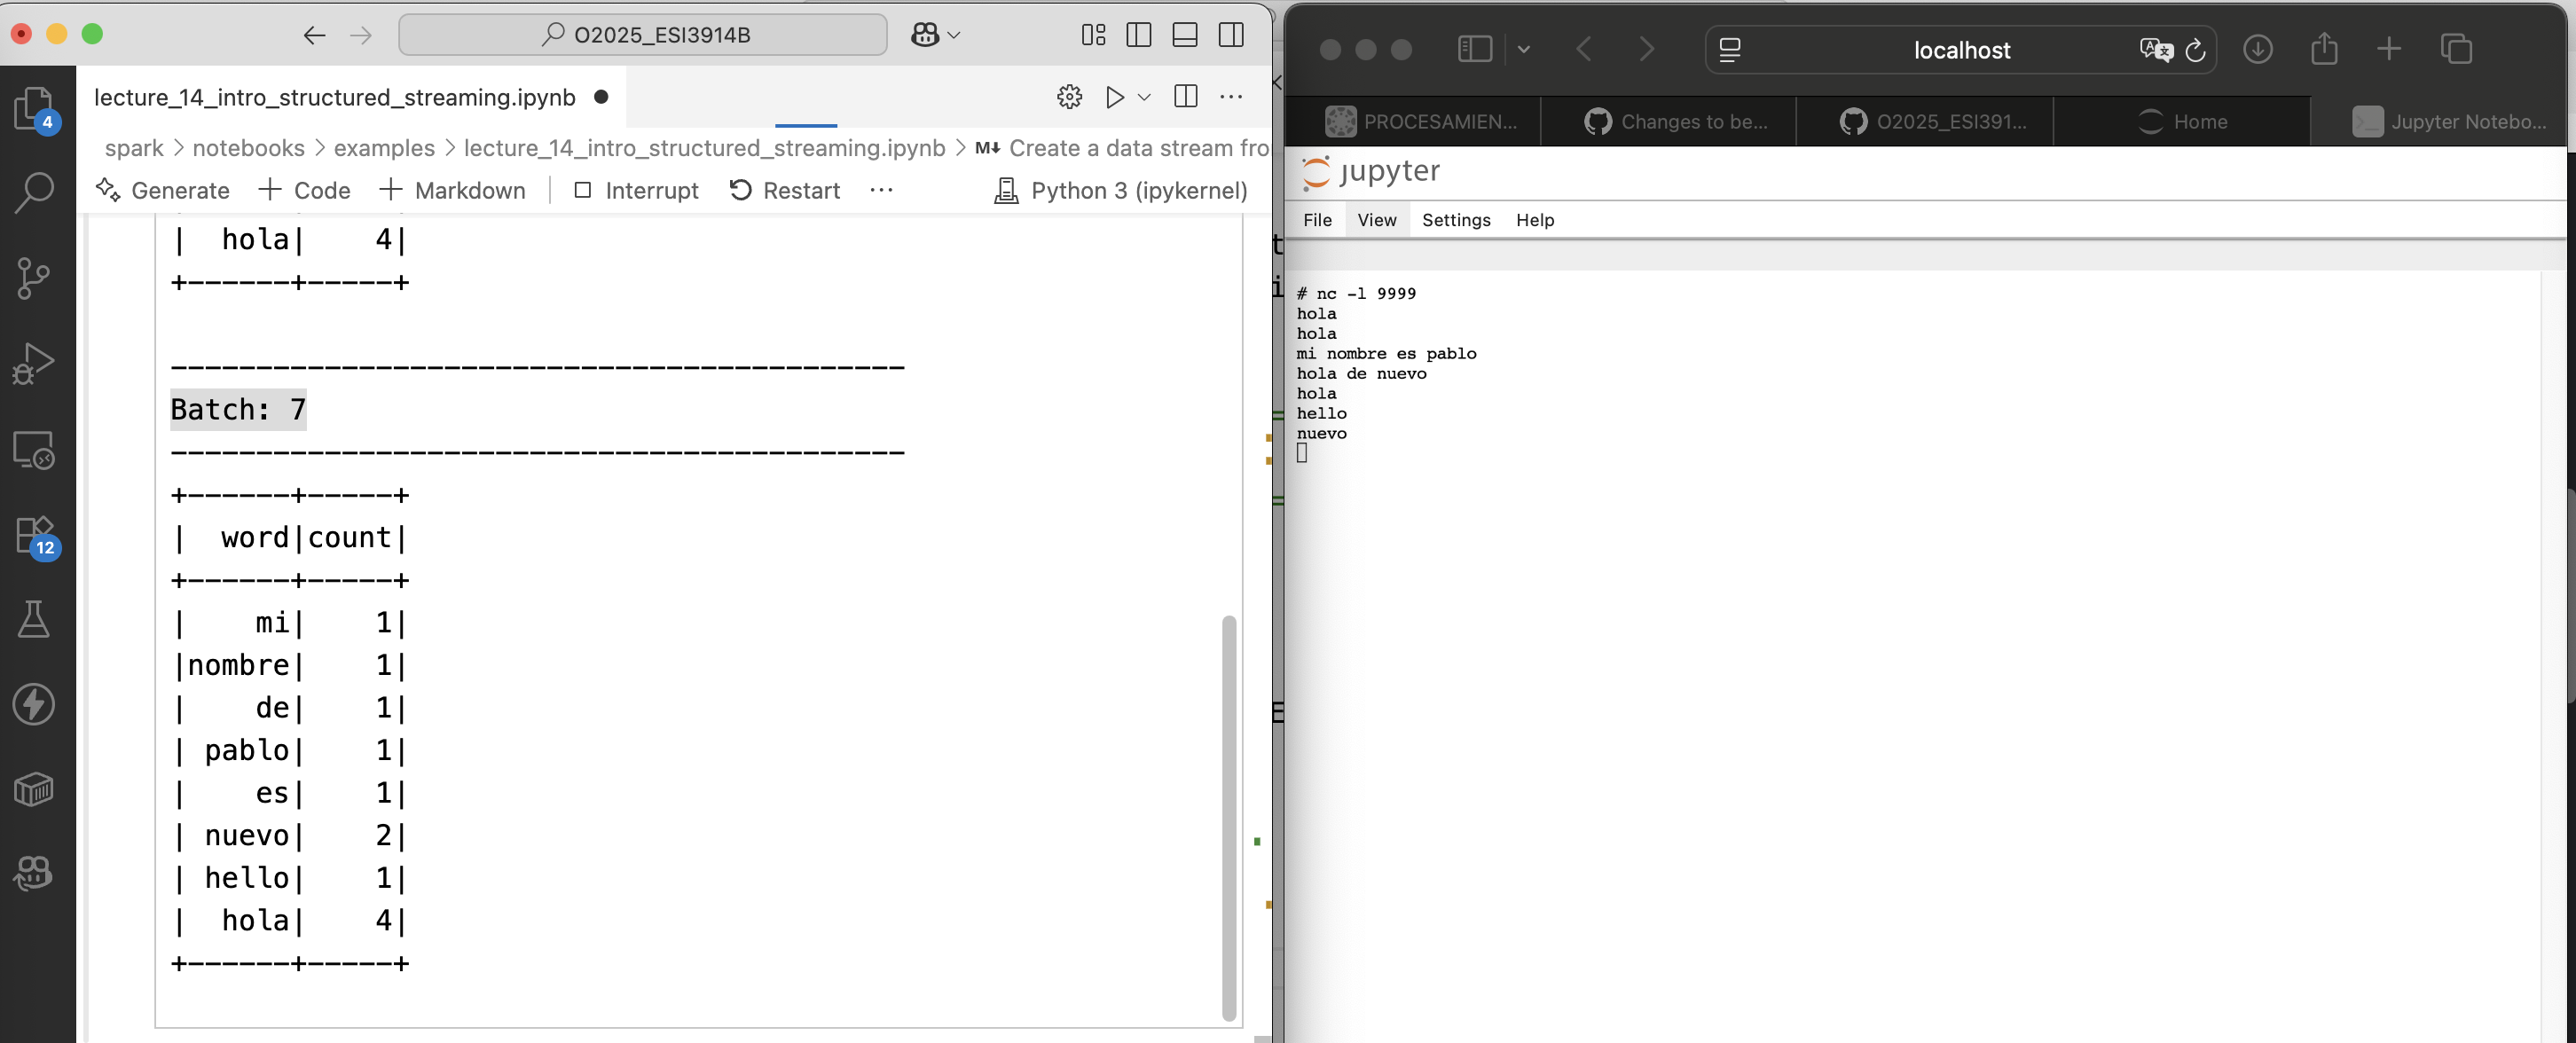

# Create a data stream from files

In [5]:
!ls data/structured_streaming_names/
!pwd

/opt/spark/work-dir


In [9]:
from pcamarillor.spark_utils import SparkUtils

names_schema = SparkUtils.generate_schema([("name", "string"), ("gpa", "float")])

names_df = spark.readStream \
            .format("json") \
            .schema(names_schema) \
            .load("/opt/spark/work-dir/data/structured_streaming_names/")

query = names_df.writeStream \
            .outputMode("append") \
            .format("console") \
            .start()

query.awaitTermination(600) # Wait 30 seconds before closing the stream

-------------------------------------------
Batch: 0
-------------------------------------------
+---------------+-------+
|           name|    gpa|
+---------------+-------+
|           NULL|   NULL|
|           NULL|   NULL|
|           NULL|   NULL|
|           NULL|   NULL|
|Jaime_contreras|    3.6|
| josé juan díaz|    0.0|
|  Axel Gallardo|    2.6|
| Axel Fernandez|   9.21|
|   Luis Santana|    0.8|
|    Axel Escoto|    0.7|
|  Jaime Galindo|    4.0|
|     Luis Bravo|    4.0|
|       Santiago|-1236.4|
|    Luis Pelayo|    0.1|
|      Sebastian|    2.1|
|       Bernardo|    3.9|
|       Quintero|    3.5|
|        Roberto|    3.5|
|        Antonia|    9.5|
|           Juan|    0.4|
+---------------+-------+
only showing top 20 rows
-------------------------------------------
Batch: 21
-------------------------------------------
-------------------------------------------
Batch: 1
-------------------------------------------
+----+---+
|name|gpa|
+----+---+
+----+---+

+----+---+
|na

False

In [10]:
sc.stop()